# Analysis

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
import datetime
import matplotlib.pyplot as plt 
import seaborn
# define Seaborn color palette to use 
palette_color = seaborn.color_palette('bright')
import plotly.express as px


from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pyspark.sql.types as T 

In [30]:
# Create a Spark session now to access functionalities of Spark
spark = (SparkSession.builder.appName('Analysis')
.master("spark://10.131.7.106:7077")
.config("spark.driver.memory", "20G")
.config("spark.executor.cores", "2")
.config("spark.driver.cores", "2")
.config("spark.executor.pyspark.memory", "30G")
.config("spark.dynamicAllocation.enabled", "true")
.getOrCreate() 
)

spark

In [31]:
df = spark.read.parquet("data/Clean_Data/clean_all")
# df = spark.read.parquet("data/Clean_Data/clean_0.1")
# df = spark.read.parquet("data/Clean_Data/clean_0.01")

In [32]:
df.count()

54343518

In [33]:
df.dtypes

[('FL_DATE', 'timestamp'),
 ('OP_CARRIER', 'string'),
 ('OP_CARRIER_FL_NUM', 'int'),
 ('ORIGIN', 'string'),
 ('DEST', 'string'),
 ('CRS_DEP_TIME', 'timestamp'),
 ('DEP_TIME', 'timestamp'),
 ('DEP_DELAY', 'double'),
 ('TAXI_OUT', 'double'),
 ('WHEELS_OFF', 'timestamp'),
 ('WHEELS_ON', 'timestamp'),
 ('TAXI_IN', 'double'),
 ('CRS_ARR_TIME', 'timestamp'),
 ('ARR_TIME', 'timestamp'),
 ('ARR_DELAY', 'double'),
 ('CANCELLED', 'double'),
 ('CANCELLATION_CODE', 'string'),
 ('DIVERTED', 'double'),
 ('CRS_ELAPSED_TIME', 'double'),
 ('ACTUAL_ELAPSED_TIME', 'double'),
 ('AIR_TIME', 'double'),
 ('DISTANCE', 'double'),
 ('CARRIER_DELAY', 'double'),
 ('WEATHER_DELAY', 'double'),
 ('NAS_DELAY', 'double'),
 ('SECURITY_DELAY', 'double'),
 ('LATE_AIRCRAFT_DELAY', 'double'),
 ('CANCELLATION_CODE_EXPLAINED', 'string')]

## Basic

In [34]:
# Top 10 carriers that have the highest number of flights
carriers_flight_count_df = df.groupBy(F.col('OP_CARRIER')).count().orderBy(F.col('count').desc())
top_10 = carriers_flight_count_df.limit(10).toPandas()
top_10 = top_10.rename(columns={'OP_CARRIER':'Carrier'})
top_10

,Carrier,count
0,WN,10743988
1,DL,6892597
2,AA,5765343
3,OO,5488915
4,EV,4523555
5,UA,4205093
6,MQ,2920259
7,US,2657286
8,B6,2178959
9,AS,1414778


Text(0.5, 1.0, 'Top 10 Carriers by number of flights')

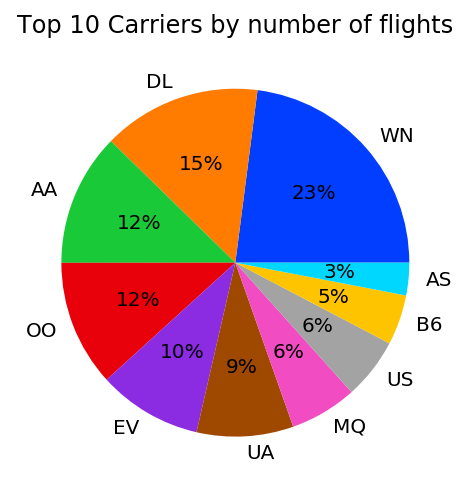

In [35]:
data = top_10['count']
keys = top_10['Carrier']

# displaying the title
plt.title('Top 10 Carriers by number of flights')

# plotting data on chart 
fig = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 

In [41]:
# Count number of cancellations per code/reason
carriers_flight_count_df = df.filter(F.col('CANCELLATION_CODE').isNotNull()).groupBy(F.col('CANCELLATION_CODE'), F.col('CANCELLATION_CODE_EXPLAINED')).count()
cancellation_reasons = carriers_flight_count_df.toPandas()

Text(0.5, 1.0, 'Reasons for flight cancellations')

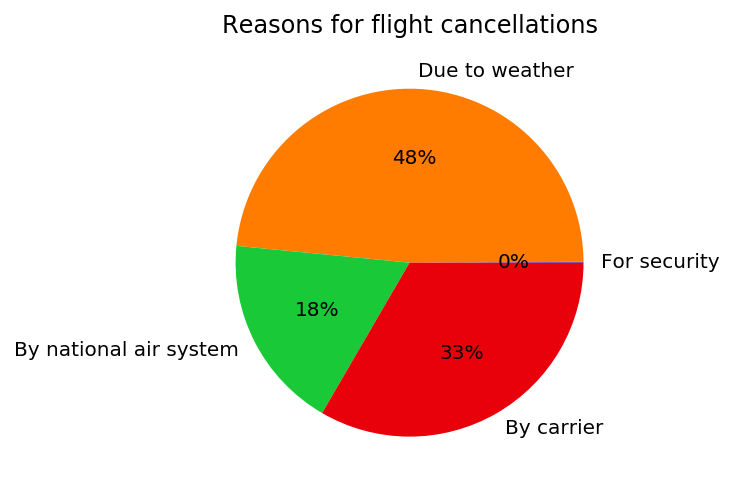

In [42]:
data = cancellation_reasons['count']
keys = cancellation_reasons['CANCELLATION_CODE_EXPLAINED']

# define Seaborn color palette to use 
palette_color = seaborn.color_palette('bright') 

# displaying the title
plt.title('Reasons for flight cancellations')

# plotting data on chart 
fig = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
# plt.savefig("reasons_cancellation.svg")

In [36]:
# Get flights that are delayed (have departure delay time > 0)
departure_delay_df = df.filter(F.col('DEP_DELAY') > 0).select('OP_CARRIER' , 'OP_CARRIER_FL_NUM', 'DEP_DELAY').orderBy(F.col('DEP_DELAY').desc())
# Top 10 flights with longest departure delay time (in minutes)
top_10_delay_flights = departure_delay_df.limit(10).toPandas()
top_10_delay_flights

,OP_CARRIER,OP_CARRIER_FL_NUM,DEP_DELAY
0,AA,611,2755.0
1,NW,598,2445.0
2,AA,1389,2402.0
3,AA,239,2208.0
4,AA,1164,2149.0
5,AA,1164,2040.0
6,AA,1242,2032.0
7,AA,1322,1988.0
8,AA,1202,1975.0
9,AA,2604,1970.0


In [37]:
# Top 10 carriers that have the highest number of delay flights 
top_10_delay_carriers = departure_delay_df.groupBy(F.col('OP_CARRIER')).count().orderBy(F.col('count').desc())
top_10_delay_carriers = top_10_delay_carriers.limit(10).toPandas()
top_10_delay_carriers = top_10_delay_carriers.rename(columns={'OP_CARRIER':'Carrier'})
top_10_delay_carriers

,Carrier,count
0,WN,5417484
1,DL,2212883
2,AA,2066426
3,UA,1723634
4,OO,1613490
5,EV,1511385
6,MQ,957968
7,B6,814978
8,US,754703
9,FL,376721


Text(0.5, 1.0, 'Top 10 Carriers by number of delay flights')

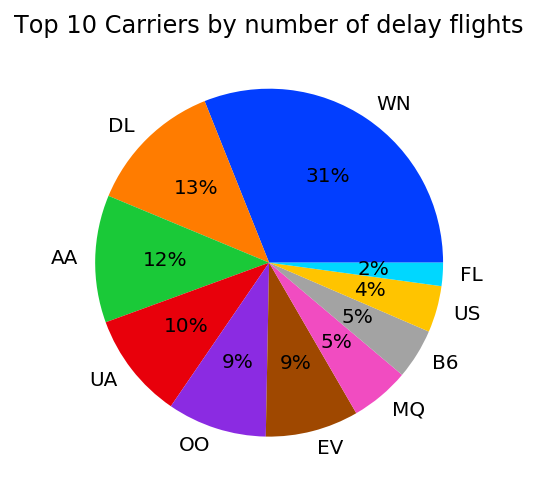

In [38]:
data = top_10_delay_carriers['count']
keys = top_10_delay_carriers['Carrier']

# define Seaborn color palette to use 
palette_color = seaborn.color_palette('bright') 

# displaying the title
plt.title('Top 10 Carriers by number of delay flights')

# plotting data on chart 
fig = plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%') 

## Time 

In [44]:
df.show(n=1, vertical = True)

-RECORD 0------------------------------------------
 FL_DATE                     | 2016-01-01 00:00:00 
 OP_CARRIER                  | DL                  
 OP_CARRIER_FL_NUM           | 1248                
 ORIGIN                      | DTW                 
 DEST                        | LAX                 
 CRS_DEP_TIME                | 2016-01-01 19:35:00 
 DEP_TIME                    | 2016-01-01 19:35:00 
 DEP_DELAY                   | 0.0                 
 TAXI_OUT                    | 23.0                
 WHEELS_OFF                  | 2016-01-01 19:58:00 
 WHEELS_ON                   | 2016-01-01 21:07:00 
 TAXI_IN                     | 13.0                
 CRS_ARR_TIME                | 2016-01-01 21:44:00 
 ARR_TIME                    | 2016-01-01 21:20:00 
 ARR_DELAY                   | -24.0               
 CANCELLED                   | 0.0                 
 CANCELLATION_CODE           | null                
 DIVERTED                    | 0.0                 
 CRS_ELAPSED

# Select the appropiate aggregation levels

In [47]:
# aggregation_levels = [F.year, F.month, F.dayofyear, F.dayofmonth, F.dayofweek, F.hour, F.minute]

# aggregation_level_names = ["year", "month", "dayofyear", "dayofmonth", "dayofweek", "hour", "minute"]

aggregation_levels = [F.hour]

aggregation_level_names = ["hour"]

Planned Flight Depature times Aggregated


Text(0.5, 1.0, 'hour')

<function matplotlib.pyplot.show(*args, **kw)>

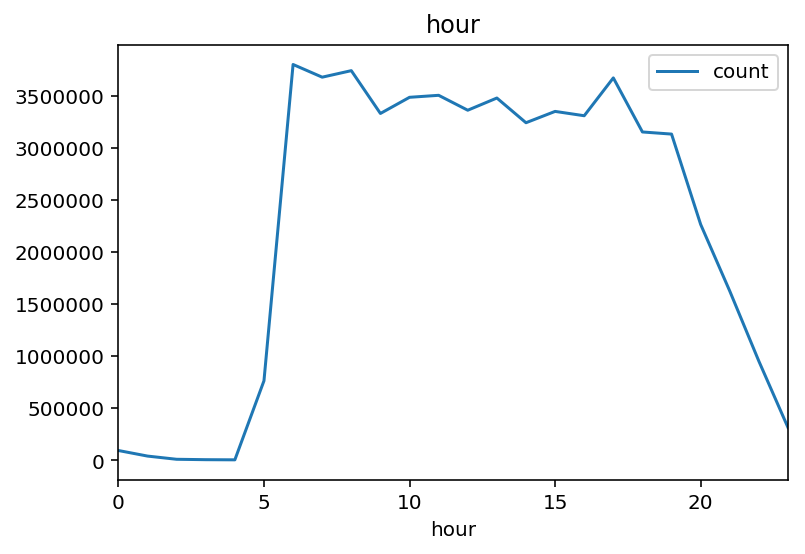

In [48]:
print("Planned Flight Depature times Aggregated")
for aggregation_level, aggregation_level_name in zip(aggregation_levels, aggregation_level_names):
    
    counts = df.groupBy(aggregation_level(F.col('CRS_DEP_TIME')).alias(aggregation_level_name)).count()
    counts = counts.orderBy(F.col(aggregation_level_name).desc())
    # Show the result
#     counts.show()
    
    #plot counts
    counts_pd = counts.toPandas()
    counts_pd.plot(x = aggregation_level_name, y = "count")
    plt.title(aggregation_level_name)
    plt.show




Mean Delay


Text(0.5, 1.0, 'hour')

([<matplotlib.axis.XTick at 0x7f716fddda58>,
 <a list of 12 Text xticklabel objects>)

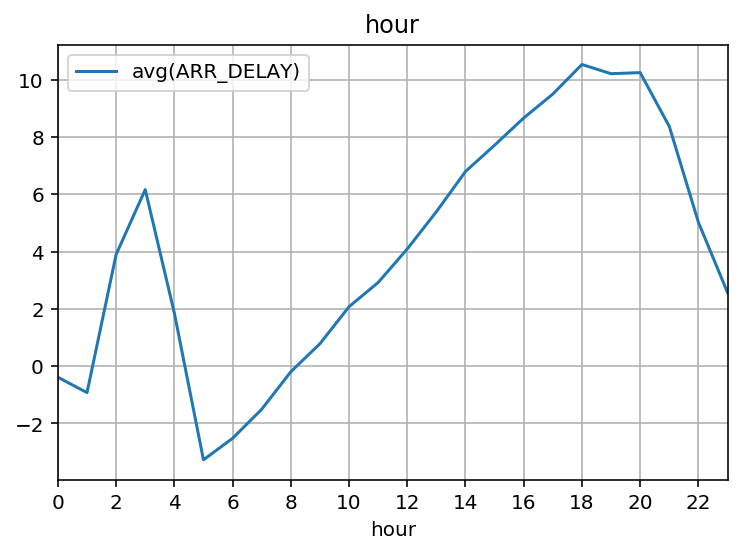

In [58]:
print("Mean Delay")
for aggregation_level, aggregation_level_name in zip(aggregation_levels, aggregation_level_names):
    
    counts = df.groupBy(aggregation_level(F.col('CRS_DEP_TIME')).alias(aggregation_level_name)).mean()
    counts = counts.orderBy(F.col(aggregation_level_name).desc()).cache()
    # Show the result
    #counts.show()
    
    #plot counts
    counts_pd = counts.toPandas()
    counts_pd.plot(x = aggregation_level_name, y ="avg(ARR_DELAY)")
    plt.title(aggregation_level_name)
    plt.xticks(np.arange(0,24,2))
    plt.grid()
    plt.savefig("delay-over-day-hour.svg")
    
#     fig = px.line(counts, x=aggregation_level_name, y=["avg(ARR_DELAY)"], title=aggregation_level_name)
#     fig.show()
    




### correlate delay with number of outgoing flighs
### delay increases during the day